# Missing Data Experiments for MSc Thesis

This notebook investigates the impact of missing data on credit scoring models and compares different methods for handling missingness. It is part of the MSc thesis project, focusing on understanding and addressing missing data in training and evaluation contexts.

## Objectives
1. Simulate synthetic credit scoring data.
2. Introduce missing data with different mechanisms: MCAR, MAR, MNAR.
3. Experiment with imputation methods and their impact on model performance.
4. Train and evaluate a classification model on imputed data.

## Structure
- **Simulate Data**: Generate synthetic credit scoring data.
- **Introduce Missing Data**: Create missing values with varying mechanisms.
- **Handle Missing Data**: Apply imputation techniques to handle missingness.
- **Train and Evaluate Models**: Measure the performance impact of imputation methods.


## Libraries Used
- **NumPy and Pandas**: For data manipulation and processing.
- **Matplotlib and Seaborn**: For data visualization.
- **Scikit-learn**: For data splitting, imputation, model training, and evaluation.

These libraries provide the foundational tools for handling missing data and analyzing their impact on models.


In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Ensure plots are displayed inline
%matplotlib inline

from src.data_simulator import DataSimulator
from src.missing_data_handler import MissingDataHandler
from src.model_trainer import ModelTrainer
from src.evaluation import Evaluation
from src.utils import split_data, visualize_results

ModuleNotFoundError: No module named 'src'

## Simulating Data
We simulate a credit scoring dataset with the following features:
- **Age**: Age of the applicant.
- **Income**: Annual income in monetary units.
- **DebtRatio**: Ratio of debt to income.
- **RepaymentStatus**: Binary target variable indicating if the applicant repaid the loan (1 = repaid, 0 = defaulted).

This dataset will be used to test the impact of missing data and imputation methods on model performance.


In [3]:
# Simulating a synthetic credit scoring dataset
def simulate_data(n_samples=10000, seed=42):
    """
    Generates a synthetic credit scoring dataset with features and a binary target.
    Parameters:
    - n_samples: Number of rows in the dataset.
    - seed: Random seed for reproducibility.
    
    Returns:
    - A pandas DataFrame containing simulated features and target labels.
    """
    np.random.seed(seed)
    age = np.random.randint(18, 70, n_samples)  # Age of applicants
    income = np.random.randint(20000, 150000, n_samples)  # Annual income
    debt_ratio = np.random.uniform(0.1, 1.0, n_samples)  # Debt-to-income ratio
    repayment_status = (income / (debt_ratio * 10000) > 3).astype(int)  # Repayment status
    
    data = pd.DataFrame({
        'Age': age,
        'Income': income,
        'DebtRatio': debt_ratio,
        'RepaymentStatus': repayment_status
    })
    return data

# Generate and display the first few rows of the dataset
data = simulate_data()
data.head()


,Age,Income,DebtRatio,RepaymentStatus
0,56,29930,0.253910,1
1,69,23285,0.483282,1
2,46,143637,0.268456,1
3,32,55863,0.795974,1
4,60,36704,0.526935,1


## Missing Data Mechanisms
- **MCAR (Missing Completely at Random)**: Data is missing without any dependency on observed or unobserved data.
- **MAR (Missing at Random)**: Missingness depends on observed data (e.g., higher income → less missingness).
- **MNAR (Missing Not at Random)**: Missingness depends on the value of the variable itself (e.g., lower age → more missingness).

This step introduces missing data based on the chosen mechanism, simulating real-world scenarios.


In [8]:
# Function to introduce missing data
def introduce_missingness(data, missing_rate=0.2, mechanism='MCAR'):
    """
    Introduces missing data into the dataset based on the selected missingness mechanism.
    """
    data_missing = data.copy()
    n_samples = len(data)
    n_missing = int(n_samples * missing_rate)
    
    if mechanism == 'MCAR':  # Missing Completely at Random
        missing_indices = np.random.choice(data.index, n_missing, replace=False)
        data_missing.loc[missing_indices] = np.nan
    
    elif mechanism == 'MAR':  # Missing at Random
        # Example: Missingness probability is related to 'Income' column
        prob = 1 - (data['Income'] / data['Income'].max())
        prob = prob / prob.sum()  # Normalize to sum to 1
        missing_indices = np.random.choice(data.index, n_missing, replace=False, p=prob)
        data_missing.loc[missing_indices] = np.nan
    
    elif mechanism == 'MNAR':  # Missing Not at Random
        # Example: Missingness probability is related to 'RepaymentStatus' column
        prob = 1 - (data['RepaymentStatus'] / data['RepaymentStatus'].max())
        prob = prob / prob.sum()  # Normalize to sum to 1
        missing_indices = np.random.choice(data.index, n_missing, replace=False, p=prob)
        data_missing.loc[missing_indices] = np.nan
    
    return data_missing


# Apply MCAR mechanism to the dataset
data_mcar = introduce_missingness(data, missing_rate=0.2, mechanism='MCAR')
data_mcar.head()


,Age,Income,DebtRatio,RepaymentStatus
0,56.0,29930.0,0.253910,1.0
1,69.0,23285.0,0.483282,1.0
2,46.0,143637.0,0.268456,1.0
3,32.0,55863.0,0.795974,1.0
4,NaN,NaN,NaN,NaN


## Visualizing Missing Data
The heatmap below shows the presence of missing data in the dataset. Yellow indicates missing values, while purple represents observed values. This helps in understanding the extent and distribution of missingness.


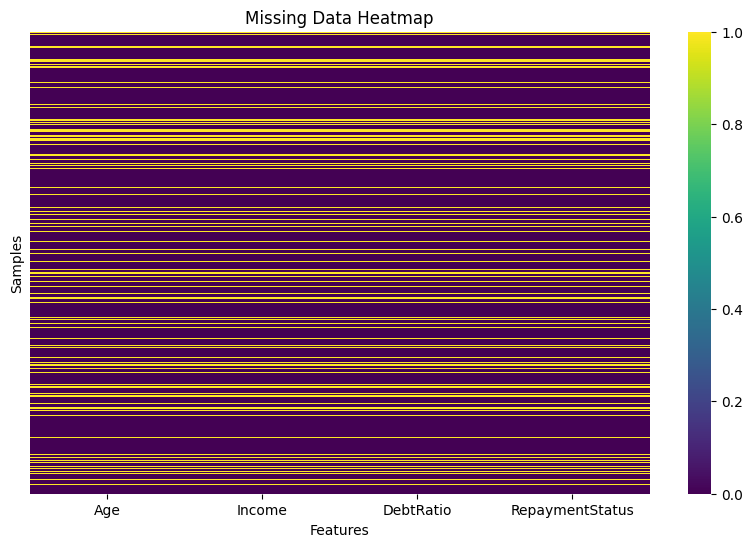

In [9]:
def plot_missingness(data):
    """
    Plots a heatmap showing the presence of missing data in the dataset.
    """
    # Set figure size for better visibility
    plt.figure(figsize=(10, 6))
    
    # Create heatmap with improved settings
    sns.heatmap(data.isnull(), 
                cbar=True,
                cmap='viridis',
                yticklabels=False)  # Hide y-axis labels to reduce clutter
    
    plt.title('Missing Data Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.show()

# Visualize missingness in the dataset
plot_missingness(data_mcar)

## Handling Missing Data
### Imputation Strategies
- **Mean**: Replaces missing values with the column mean.
- **Median**: Replaces missing values with the column median.
- **Most Frequent**: Replaces missing values with the most common value in the column.

In this step, we apply the mean imputation strategy to handle missing data. The imputed dataset replaces missing values while preserving the original structure.


In [10]:
# Function to apply imputation methods
def impute_missing_data(data, strategy='mean'):
    """
    Imputes missing data in the dataset using the specified strategy.
    Parameters:
    - data: DataFrame with missing values.
    - strategy: Imputation strategy ('mean', 'median', 'most_frequent').
    
    Returns:
    - A DataFrame with imputed values.
    """
    imputer = SimpleImputer(strategy=strategy)
    imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    return imputed_data

# Apply mean imputation to the dataset
data_imputed = impute_missing_data(data_mcar, strategy='mean')
data_imputed.head()


,Age,Income,DebtRatio,RepaymentStatus
0,56.000000,29930.000000,0.253910,1.000000
1,69.000000,23285.000000,0.483282,1.000000
2,46.000000,143637.000000,0.268456,1.000000
3,32.000000,55863.000000,0.795974,1.000000
4,43.467875,84431.032125,0.554480,0.984875


## Splitting the Data
To evaluate the model's performance, the dataset is split into:
- **Training Set**: 70% of the data to train the model.
- **Test Set**: 30% of the data to evaluate the model's generalization.

This ensures that the model's performance is evaluated on unseen data.


In [11]:
# Split the imputed data into training and test sets
def split_data(data):
    """
    Splits the dataset into training and test sets.
    """
    X = data.drop(columns=['RepaymentStatus'])
    y = data['RepaymentStatus']
    return train_test_split(X, y, test_size=0.3, random_state=42)

# Perform the split
X_train, X_test, y_train, y_test = split_data(data_imputed)


## Training a Model
We train a **Random Forest Classifier**, a robust ensemble learning method, using the imputed training data. This model combines multiple decision trees to improve prediction accuracy and reduce overfitting.

### Feature Importances
The trained model also provides feature importance scores, helping to understand which features contribute most to the prediction.


In [12]:
# Train a Random Forest Classifier
def train_model(X_train, y_train):
    """
    Trains a Random Forest model on the given data.
    """
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

# Train the model and display the feature importances
model = train_model(X_train, y_train)
print("Feature Importances:", model.feature_importances_)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

## Model Evaluation
### Metrics
1. **Accuracy**: Percentage of correct predictions.
2. **AUC-ROC**: Area under the Receiver Operating Characteristic curve, measuring model discrimination ability.
3. **Classification Report**: Detailed performance metrics (precision, recall, F1-score) for each class.

These metrics help quantify the impact of missing data and imputation methods on model performance.


In [10]:
# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model's performance using accuracy and AUC-ROC.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print("Accuracy:", accuracy)
    print("AUC-ROC:", auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return accuracy, auc

# Evaluate the trained model
evaluate_model(model, X_test, y_test)


Accuracy: 0.9923333333333333
AUC-ROC: 0.9267626030685733

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.60      0.73        52
         1.0       0.99      1.00      1.00      2948

    accuracy                           0.99      3000
   macro avg       0.97      0.80      0.86      3000
weighted avg       0.99      0.99      0.99      3000



(0.9923333333333333, np.float64(0.9267626030685733))

## Experimenting with Missingness and Imputation
### Objective
To understand the impact of different missing data mechanisms (MCAR, MAR, MNAR) and imputation strategies on model performance.

### Results
The results are summarized in a table showing accuracy and AUC for each combination of mechanism and strategy. This highlights the best approaches for handling missing data in credit scoring contexts.


In [13]:
# Experiment function
def experiment_with_mechanisms(data, mechanisms=['MCAR', 'MAR', 'MNAR'], strategies=['mean', 'median', 'most_frequent']):
    """
    Runs experiments for different missingness mechanisms and imputation strategies.
    """
    results = []
    for mechanism in mechanisms:
        data_missing = introduce_missingness(data, missing_rate=0.2, mechanism=mechanism)
        for strategy in strategies:
            data_imputed = impute_missing_data(data_missing, strategy=strategy)
            X_train, X_test, y_train, y_test = split_data(data_imputed)
            model = train_model(X_train, y_train)
            accuracy, auc = evaluate_model(model, X_test, y_test)
            results.append({
                'Mechanism': mechanism,
                'Strategy': strategy,
                'Accuracy': accuracy,
                'AUC': auc
            })
    return pd.DataFrame(results)

# Run experiments and display results
experiment_results = experiment_with_mechanisms(data)
experiment_results


Accuracy: 0.9923333333333333
AUC-ROC: 0.9267626030685733

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.60      0.73        52
         1.0       0.99      1.00      1.00      2948

    accuracy                           0.99      3000
   macro avg       0.97      0.80      0.86      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.9923333333333333
AUC-ROC: 0.9336088351946561

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.60      0.73        52
         1.0       0.99      1.00      1.00      2948

    accuracy                           0.99      3000
   macro avg       0.97      0.80      0.86      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.992
AUC-ROC: 0.9276334672789895

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.58      0.71        52
    

ValueError: probabilities do not sum to 1

## Visualizing Results
The bar plots below show:
1. **Accuracy**: Performance comparison by mechanism and imputation strategy.
2. **AUC-ROC**: Discrimination ability comparison by mechanism and strategy.

These visualizations make it easier to interpret the impact of different approaches.


In [12]:
# Visualizing the results
def plot_results(results):
    """
    Plots the experimental results for visualization.
    """
    sns.barplot(x='Mechanism', y='Accuracy', hue='Strategy', data=results)
    plt.title('Accuracy by Missingness Mechanism and Imputation Strategy')
    plt.ylabel('Accuracy')
    plt.show()
    
    sns.barplot(x='Mechanism', y='AUC', hue='Strategy', data=results)
    plt.title('AUC-ROC by Missingness Mechanism and Imputation Strategy')
    plt.ylabel('AUC-ROC')
    plt.show()

# Plot the experimental results
plot_results(experiment_results)


NameError: name 'experiment_results' is not defined

# Conclusion
This notebook provided a framework for simulating data, introducing missingness, and testing different imputation methods in the context of credit scoring. The results demonstrate how missing data mechanisms and handling techniques affect model performance.

Next Steps:
- Use real-world data or further refine synthetic simulations.
- Extend the experiments to include advanced imputation methods (e.g., ML-based imputation).
- Explore domain-specific insights to tailor missing data strategies effectively.
